# Titanic Dataset

## Init

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Data and its structure

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 12)

In [4]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Pre-processing

### Missing values

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
print(f'Total number of records with null: {(data.isna().sum(axis=1) > 0).sum()}')

Total number of records with null: 708


In [7]:
data.isna().sum(axis=1).value_counts()

1    550
0    183
2    158
Name: count, dtype: int64

### Clean, fill-missing and encode

Remove unnecessary columns

In [8]:
data.drop(['Name', 'Ticket'], axis=1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S
887,888,1,1,female,19.0,0,0,30.0000,B42,S
888,889,0,3,female,NaN,1,2,23.4500,NaN,S
889,890,1,1,male,26.0,0,0,30.0000,C148,C


#### `Embarked` column

In [9]:
data[data.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
data.Embarked.value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

Impute missing `Embarked` values with the most likely value i.e. `S`

In [11]:
# one way
# mostFrequentEmbarkedValue = data.Embarked[data.Embarked.value_counts(dropna=False).argmax()]
# print(f'most frequent embarked value: {mostFrequentEmbarkedValue}')
# data.Embarked = data.Embarked.fillna(mostFrequentEmbarkedValue)
# data.Embarked.value_counts(dropna=False)

In [12]:
# better way
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data[['Embarked']] = imputer.fit_transform(data[['Embarked']])
data.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
data.Embarked = LabelEncoder().fit_transform(data.Embarked)
data.Embarked.value_counts()

Embarked
2    646
0    168
1     77
Name: count, dtype: int64

#### `Cabin` column

In [14]:
data.Cabin.isna().sum()

687

Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


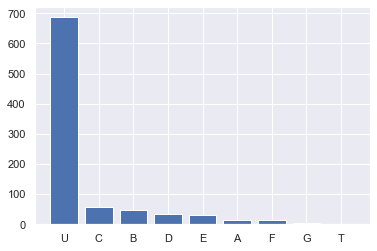

In [15]:
data.Cabin = data.Cabin.str.strip().str[:1]
data.Cabin = data.Cabin.fillna('U')
cabin_counts = data.Cabin.value_counts()
print(cabin_counts)
plt.bar(cabin_counts.index, cabin_counts.values)
plt.draw()

In [16]:
from sklearn.preprocessing import LabelEncoder
data.Cabin = LabelEncoder().fit_transform(data.Cabin)
data.Cabin.value_counts()

Cabin
8    687
2     59
1     47
3     33
4     32
0     15
5     13
6      4
7      1
Name: count, dtype: int64

#### `Sex` column

In [17]:
from sklearn.preprocessing import LabelEncoder
data.Sex = LabelEncoder().fit_transform(data.Sex)
data.Sex.value_counts()

Sex
1    577
0    314
Name: count, dtype: int64

#### `Age` column

In [18]:
data.Age.isna().sum()

177

In [19]:
from sklearn.impute import KNNImputer
selected_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
data.Age = KNNImputer(n_neighbors=2, weights='uniform').fit_transform(data[selected_columns].values)[:, 2]

Now, no more missing values remain

In [20]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Further optimisations (optional)

Recasting columns to smaller datatypes for efficiency 

In [21]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int32
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin            int32
Embarked         int32
dtype: object

In [22]:
data.memory_usage()

Index           128
PassengerId    7128
Survived       7128
Pclass         7128
Name           7128
Sex            3564
Age            7128
SibSp          7128
Parch          7128
Ticket         7128
Fare           7128
Cabin          3564
Embarked       3564
dtype: int64

In [23]:
data.Survived = data.Survived.astype('bool')

In [24]:
int_columns = data.columns[(data.dtypes=='int64') | (data.dtypes=='int32')] 
data[int_columns] = data[int_columns].astype('int8')

In [35]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,8,2
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,True,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,8,2
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2
4,5,False,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,8,2


## EDA

### Survival Statistics

#### Sex Stats

In [26]:
pd.cut(data.Age, np.arange(0, 101, 10))

0      (20, 30]
1      (30, 40]
2      (20, 30]
3      (30, 40]
4      (30, 40]
         ...   
886    (20, 30]
887    (10, 20]
888    (10, 20]
889    (20, 30]
890    (30, 40]
Name: Age, Length: 891, dtype: category
Categories (10, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (60, 70] < (70, 80] < (80, 90] < (90, 100]]

In [27]:
# pd.MultiIndex.from_arrays([])

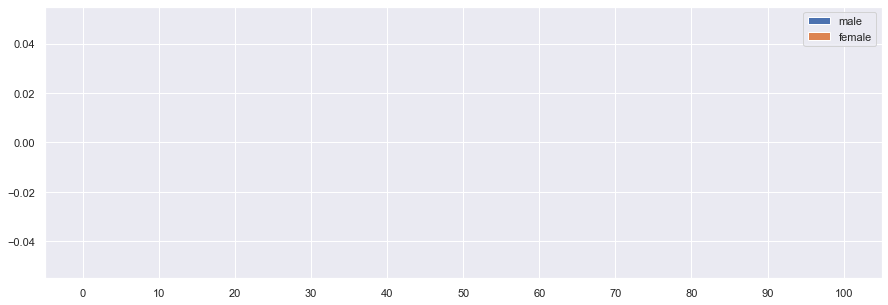

In [28]:
age_buckets = np.arange(0, 101, 10)
plt.figure().set_size_inches(15 ,5)
males_age = data[data.Sex=='male'].Age
females_age = data[data.Sex=='female'].Age
plt.hist([males_age, females_age], age_buckets, stacked=True, label=['male', 'female'])
plt.xticks(age_buckets)
plt.legend()
plt.draw()

In [29]:
print(f'Survived/Total : {data.Survived.sum()}/{data.Survived.size}')

Survived/Total : 342/891


In [30]:
data.groupby(['Sex', 'Pclass'])[['Survived']].mean().unstack()

Survived                    
Pclass         1         2         3
Sex                                 
0       0.968085  0.921053  0.500000
1       0.368852  0.157407  0.135447

In [31]:
data.pivot_table('Survived', index='Sex', columns='Pclass', aggfunc='mean')

Pclass,1,2,3
Sex,,,
0,0.968085,0.921053,0.500000
1,0.368852,0.157407,0.135447


In [34]:
data.pivot_table('Survived', ['Sex', 'Age'], 'Pclass')

Pclass       1    2     3
Sex Age                  
0   0.75   NaN  NaN  1.00
    1.00   NaN  NaN  1.00
    2.00   0.0  1.0  0.25
    3.00   NaN  1.0  0.00
    4.00   NaN  1.0  1.00
...        ...  ...   ...
1   70.00  0.0  0.0   NaN
    70.50  NaN  NaN  0.00
    71.00  0.0  NaN   NaN
    74.00  NaN  NaN  0.00
    80.00  1.0  NaN   NaN

[170 rows x 3 columns]

In [ ]:
embarked_counts = data.Embarked.value_counts()
plt.bar(embarked_counts.index, embarked_counts.values)
plt.show()

## Preprocessing

Set target (Y)

In [ ]:
Y = data.Survived.copy()

Remove non essential columns

In [ ]:
X = data.drop(columns=['PassengerId','Name', 'Survived'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
X.Sex = LabelEncoder().fit_transform(X.Sex)

In [ ]:
X.Cabin = X.Cabin.fillna('X')
X.Cabin = X.Cabin.str[:1]

### Features and targets